In [1]:
# On a fresh Julia installation, uncomment and run these once to install
# the necessary packages.
# import Pkg
# Pkg.add("ReinforcementLearning")
# Pkg.add("Flux")
# Pkg.add("StableRNGs")
# Pkg.add("IntervalSets")
# Pkg.add("GR")
# Pkg.add("Requires")
# Pkg.add("Distributions")

using ReinforcementLearning
using StableRNGs
using Flux
using Flux.Losses
using Plots
using Distributions
import Printf.@sprintf
import Plots:Animation, buildanimation  
using IntervalSets
using Random
using LinearAlgebra: norm2

# Add WaterLily. Uncomment and set path to use a raw git checkout.
# Otherwise, use Pkg.add("WaterLily").
# path_to_package = "D:/git/WaterLily.jl"
# push!(LOAD_PATH, path_to_package)
using WaterLily
include("D:/git/WaterLily.jl/examples/TwoD_Plots.jl")

sim_gif! (generic function with 1 method)

# Helper functions

In [2]:
function flowInterp(xi, arr)
    # Index below the interpolation coordinate.
    ii = [
        max(1, min(size(arr, 1)-1, Int(floor(xi[1])))),
        max(1, min(size(arr, 2)-1, Int(floor(xi[2]))))]
    
    # Local coordinate system <0, 1>. delta is 1 in both directions
    a = 1. / ((2 - 1) * (2 - 1))
    xx = [ii[1]+1 - xi[1], xi[1] - ii[1]]
    yy = [ii[2]+1 - xi[2], xi[2] - ii[2]]
    
    # Interp
    data = arr[ii[1]:ii[1]+1, ii[2]:ii[2]+1]
    b = data*yy
    res = a*(transpose(xx)*b)
    return res
end

function random_point_in_circle(x0, y0, r)
    # Generate a random angle between 0 and 2π
    angle = rand() * 2*pi
    
    # Generate a random radius between 0 and r
    # Using sqrt(rand()) generates a radius that is proportional
    # to the square root of a uniformly distributed random variable,
    # which results in a uniform distribution of points within the circle.
    # This is known as the polar coordinates method for generating
    # random points within a circle.
    radius = sqrt(rand()) * r
    
    # Calculate the x and y coordinates of the point
    x_point = x0 + radius * cos(angle)
    y_point = y0 + radius * sin(angle)
    
    # Return the x and y coordinates as a tuple
    return vcat(x_point, y_point)
end

function circle_shape(x0, y0, r, nPts::Int=101)
    angles = LinRange(0, 2*pi, nPts)
    x = x0 .+ r .* cos.(angles)
    y = y0 .+ r .* sin.(angles)
    return x, y
end

function circle(n, m, R, center; Re=250)
    U = 1.
    ν = U*R/Re
    body = AutoBody((x,t)->norm2(x .- center) - R)
    Simulation((n+2, m+2), [U, 0.], R; ν, body)
end

circle (generic function with 1 method)

# Environment definition

In [3]:
struct SwimmerEnvParams{T}
    N::Int
    M::Int
    RbyM::T
    Vmax::T
    dTargetThresholdSuccess::T
    dt::T
    max_steps::Int
end

mutable struct SwimmerEnv{A,T,R<:AbstractRNG} <: AbstractEnv
    params::SwimmerEnvParams{T}
    action_space::A
    observation_space::Space{Vector{ClosedInterval{T}}}
    state::Vector{T}
    done::Bool
    t::Int
    rng::R
    reward::T
    n_actions::Int
    # Radius and position of the cylinder
    R::T
    x0::Vector{T}
    # WaterLily simulation instance
    circ::Simulation
    # Start and end areas, RL domain size.
    x0Start::Vector{T}
    Rstart::T
    x0End::Vector{T}
    Rend::T
    rlDomainMin::Vector{T}
    rlDomainMax::Vector{T}
    # Random start time after the transients have been removed from the flow.
    tStart::Int
    # Actual start and end goal locations as well as current position.
    xStart::Vector{T}
    xEnd::Vector{T}
    pos::Vector{T}
    # Used in the reward function for determining if the agent is moving in the right direction
    dTargetOld::T
end

function SwimmerEnv(;
    T = Float64,
    N::Int = 3*2^7,
    M::Int = 2^8,
    RbyM = T(1/32),
    Vmax = T(1.2),  # When set to below 1, this makes the problem impossible without RL and energy scavenging
    dTargetThresholdSuccess = T(0.1),
    dt = T(0.5),
    max_steps = 600,  # This excludes the initial ramp-up time used to let the flow develop
    continuous::Bool = true,
    n_actions::Int = 1,
    rng = Random.GLOBAL_RNG,
)
    nStateVars = 4
    state_range_max = ones(T, nStateVars)
    action_space = -1.0..1.0
    
    # Create a simulation instance.
    # NOTE could add noise to R and x0 for each training
    # run to increase robustness and demonstrate some degree of generality.
    R = M*RbyM
    x0 = T.([M/2, M/2])
    circ = circle(N, M, R, x0)
    
    # Assign values to the RL domain. Watch the types!
    x0Start = T.([10., -4.1] .* R .+ x0)
    Rstart = T(4*R)
    x0End = T.([10., 4.1] .* R .+ x0)
    Rend = T(4*R)
    rlDomainMin = T.([1.0, -10.0] .* R .+ x0)
    rlDomainMax = T.([20.0, 10.0] .* R .+ x0)

    # Create a new instance.
    env = SwimmerEnv(
        SwimmerEnvParams(N, M, RbyM, Vmax, dTargetThresholdSuccess, dt, max_steps),
        action_space,
        Space(ClosedInterval{T}.(-state_range_max, state_range_max)),
        zeros(T, nStateVars),
        false,
        0,
        rng,
        zero(T),
        n_actions,
        # Custom fields.
        R,
        x0,
        circ,
        x0Start,
        Rstart,
        x0End,
        Rend,
        rlDomainMin,
        rlDomainMax,
        # Dummy value for the start time step. Set in reset
        0,
        # Dummy values for the start and end positions, set in reset.
        zeros(T, 2),
        zeros(T, 2),
        zeros(T, 2),
        # Dummy dTargetOld
        T(0)
    )
    
    # Reset the env.
    reset!(env)
    env
end

Random.seed!(env::SwimmerEnv, seed) = Random.seed!(env.rng, seed)

# Functions for transforming the state vector into observations. Do nothing with this for now.
# Could be useful for including angles to make them invariant via cos and sin like in the pendulum example.
# swimmer_observation(s) = [cos(s[1]), sin(s[1]), s[2]]
swimmer_observation(s) = s

RLBase.action_space(env::SwimmerEnv) = env.action_space
RLBase.state_space(env::SwimmerEnv) = env.observation_space
RLBase.reward(env::SwimmerEnv) = env.reward
RLBase.is_terminated(env::SwimmerEnv) = env.done
RLBase.state(env::SwimmerEnv) = swimmer_observation(env.state)

function assembleStateVector(xEnd, pos, vFlow)
    # State is relative position to the target (unit vector) and 
    # flow velocity at the swimmer's position (bounded to <-Uinf, Uinf>).
    vecToTarget = xEnd .- pos
    dToTarget = norm2(vecToTarget)
    vecToTarget /= max(1e-6, dToTarget)
    state = [
        vecToTarget[1],
        vecToTarget[2],
        max(-1, min(1, vFlow[1])),
        max(-1, min(1, vFlow[2]))
    ]
    return state, dToTarget
end

function RLBase.reset!(env::SwimmerEnv{A,T}) where {A,T}
    env.t = 0
    env.done = false
    env.reward = zero(T)
    
    # Reset the simulation instance.
    env.circ = circle(env.params.N, env.params.M, env.params.RbyM*env.params.M,
        [env.params.M/2, env.params.M/2])
    
    # Create a random start time to make the problem less repeatable and avoid
    # swimming in a clean flow.
    env.tStart = rand(200:300)
    
    # Generate random start and end points.
    env.xStart = random_point_in_circle(env.x0Start[1], env.x0Start[2], env.Rstart)
    env.xEnd = random_point_in_circle(env.x0End[1], env.x0End[2], env.Rend)
    env.pos = copy(env.xStart)

    # Simulate tStart time steps without running the rest of the code not to
    # feed spurious data to the RL algorithm.
    for t in 0:env.tStart
        sim_step!(env.circ, t*env.params.dt)
    end
    
    # Retrieve the flow velocity at the agent location.
    vFlow = [flowInterp(env.pos, env.circ.flow.u[:, :, 1]),
            flowInterp(env.pos, env.circ.flow.u[:, :, 2])]
    
    # Set the initial state and target distance.
    env.state, env.dTargetOld = assembleStateVector(env.xEnd, env.pos, vFlow)
    
    nothing
end

function (env::SwimmerEnv{<:ClosedInterval})(a::AbstractFloat)
    @assert a in env.action_space
    _step!(env, a)
end

function _step!(env::SwimmerEnv, a)
    env.t += 1
    
    # Take a CFD step.
    sim_step!(env.circ, (env.tStart+env.t)*env.params.dt)
        
    # Retrieve the flow velocity at the agent location.
    vFlow = [flowInterp(env.pos, env.circ.flow.u[:, :, 1]),
            flowInterp(env.pos, env.circ.flow.u[:, :, 2])]
    
    # Translate the action value in range <-1, 1> into set heading in range <0, 2pi>
    theta = max(0, min(2*pi, (a[1]+1)*pi))

    # Set velocity along the desired heading.
    vSet = [cos(theta), sin(theta)] .* env.params.Vmax
    
    # Update position using the Euler approach.
    env.pos = env.pos .+ (vSet .+ vFlow) .* env.params.dt
    
    # Set the updated state.
    env.state, dToTarget = assembleStateVector(env.xEnd, env.pos, vFlow)
    
    # Check the end condition.
    env.done = env.t >= env.params.max_steps
    
    # Compute the reward function.
    env.reward = -1*env.params.dt + 10*(env.dTargetOld - dToTarget)/env.R/env.params.Vmax
    
    if dToTarget < env.params.dTargetThresholdSuccess*env.R
        env.reward += 200
        env.done = true
    end

    # Check if domain exceeded.
    if (
            (env.pos[1] < env.rlDomainMin[1]) || (env.pos[1] > env.rlDomainMax[1]) ||
            (env.pos[2] < env.rlDomainMin[2]) || (env.pos[2] > env.rlDomainMax[2])
        )
        env.done = true
        env.reward = -200
    end
    
    # Store the target distance.
    env.dTargetOld = dToTarget

    nothing
end

_step! (generic function with 1 method)

# RL settings

## DDPG

Changelog
- v1:
    + moved to 150k time steps from 50k
    + changed max speed to 0.8 from 1.2
    + increased max duration to 600 from 500
    
    => doesn't manage to figure out that it needs to scavange energy
- v2:
    + changed speed back to 1.2
    + increased dt weighting in the reward to -2 from -1 to see if the agent
        will follow the flow for extra speed at all
        
    => seems to have spoiled everything.
- v3:
    + reward back to -1 for dt, speed still at 1.2, long training
    
    => training went ok but evaluation happened to be poor. Need the net to be
    more expressive?

TODO evaluation on a number of episodes in deterministic mode

In [4]:
function RL.Experiment(
    ::Val{:JuliaRL},
    ::Val{:DDPG},
    ::Val{:Swimmer},
    ::Nothing;
    seed=123
)
    rng = StableRNG(seed)
    env = SwimmerEnv(T = Float32, rng = rng)
    ns = length(state(env))
    na = 1
    
    nTrainingSteps = 150_000
    # actFun = relu  # The most basic function one can think of.
    actFun = gelu  # Worked the best with pytorch.
    nNeurons = 128
    lr = 0.0005
    
    init = glorot_uniform(rng)

    create_actor() = Chain(
        Dense(ns, nNeurons, actFun; init=init),
        Dense(nNeurons, nNeurons, actFun; init=init),
        Dense(nNeurons, na, tanh; init=init),
    ) |> gpu

    create_critic() = Chain(
        Dense(ns + na, nNeurons, actFun; init=init),
        Dense(nNeurons, nNeurons, actFun; init=init),
        Dense(nNeurons, 1; init=init),
    ) |> gpu

    agent = Agent(
        policy = DDPGPolicy(
            behavior_actor = NeuralNetworkApproximator(
                model = create_actor(),
                optimizer = ADAM(lr),
            ),
            behavior_critic = NeuralNetworkApproximator(
                model = create_critic(),
                optimizer = ADAM(lr),
            ),
            target_actor = NeuralNetworkApproximator(
                model = create_actor(),
                optimizer = ADAM(lr),
            ),
            target_critic = NeuralNetworkApproximator(
                model = create_critic(),
                optimizer = ADAM(lr),
            ),
            γ = 0.99f0,
            ρ = 0.995f0,
            na = na,
            batch_size = 256,
            start_steps = 1000,
            start_policy = RandomPolicy(-1.0..1.0; rng=rng),
            update_after = 1000,
            update_freq = 10,
            act_limit = 1.0,
            act_noise = 0.1,
            rng = rng
        ),
        trajectory = CircularArraySARTTrajectory(
            capacity = 20_000,
            state = Vector{Float32} => (ns,),
            action = Float32 => (na, ),
        ),
    )

    stop_condition = StopAfterStep(nTrainingSteps, is_show_progress=!haskey(ENV, "CI"))
    hook = TotalRewardPerEpisode()
    Experiment(agent, env, stop_condition, hook, "")
end

## TD3

In [5]:
# function RL.Experiment(
#     ::Val{:JuliaRL},
#     ::Val{:TD3},
#     ::Val{:Swimmer},
#     ::Nothing;
#     seed = 123,
# )
#     nTrainingSteps = 100_000
#     lr = 1e-3
#     n_actor = 32
#     n_critic = 32
    
#     rng = StableRNG(seed)

#     env = SwimmerEnv(T = Float32, rng = rng)
#     ns = length(state(env))
    
#     # inner_env = SwimmerEnv(T = Float32, rng = rng)
#     # ns = length(state(inner_env))
    
#     na = 1
    
# #     N_ENV = 8
# #     UPDATE_FREQ = 512
# #     env = MultiThreadEnv([
# #         SwimmerEnv(T = Float32, rng = StableRNG(hash(seed + i))) for i in 1:N_ENV
# #     ])
    
#     init = glorot_uniform(rng)

#     # === TD3 ===
#     create_actor() = Chain(
#         Dense(ns, n_actor, relu; init = init),
#         Dense(n_actor, n_actor, relu; init = init),
#         Dense(n_actor, na, tanh; init = init),
#     ) |> gpu

#     create_critic_model() = Chain(
#         Dense(ns + na, n_critic, relu; init = init),
#         Dense(n_critic, n_critic, relu; init = init),
#         Dense(n_critic, na; init = init),
#     ) |> gpu

#     create_critic() = TD3Critic(create_critic_model(), create_critic_model())

#     agent = Agent(
#         policy = TD3Policy(
#             behavior_actor = NeuralNetworkApproximator(
#                 model = create_actor(),
#                 optimizer = ADAM(lr),
#             ),
#             behavior_critic = NeuralNetworkApproximator(
#                 model = create_critic(),
#                 optimizer = ADAM(lr),
#             ),
#             target_actor = NeuralNetworkApproximator(
#                 model = create_actor(),
#                 optimizer = ADAM(lr),
#             ),
#             target_critic = NeuralNetworkApproximator(
#                 model = create_critic(),
#                 optimizer = ADAM(lr),
#             ),
#             γ = 0.99f0,
#             ρ = 0.99f0,
#             batch_size = 64,
#             start_steps = 1000,
#             start_policy = RandomPolicy(-1.0..1.0; rng = rng),
#             update_after = 1000,
#             update_freq = 10,
#             policy_freq = 2,
#             target_act_limit = 1.0,
#             target_act_noise = 0.1,
#             act_limit = 1.0,
#             act_noise = 0.1,
#             rng = rng,
#         ),
#         trajectory = CircularArraySARTTrajectory(
#             capacity = 20_000,
#             state = Vector{Float32} => (ns,),
#             action = Float32 => (),
#             # state = Matrix{Float32} => (ns, N_ENV),
#             # action = Vector{Float32} => (N_ENV,),
#         ),
#     )

#     stop_condition = StopAfterStep(nTrainingSteps, is_show_progress=!haskey(ENV, "CI"))
#     hook = TotalRewardPerEpisode()
#     # hook = TotalBatchRewardPerEpisode(1)
#     Experiment(agent, env, stop_condition, hook, "")
# end

# Training

In [6]:
# Traing several times to assess variability in NN performance depending
# on the random initialisation and stochastic optimisation of weights.
nModels = 1
models = []
for iModel in 1:nModels
    ex = E`JuliaRL_DDPG_Swimmer`
    # ex = E`JuliaRL_TD3_Swimmer`
    run(ex)
    push!(models, ex)
end

┌ Info: The GPU function is being called but the GPU is not accessible. 
└ Defaulting back to the CPU. (No action is required if you want to run on the CPU).


Progress: 100%|█████████████████████████████████████████| Time: 8:28:04m45m


              ⠀⠀⠀⠀⠀⠀⠀⠀⠀Total reward per episode⠀⠀⠀⠀⠀⠀⠀⠀⠀ 
              ┌────────────────────────────────────────┐ 
          300 │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              │⠀⠀⠀⠀⡀⢠⣀⠀⡄⠀⢀⢀⣠⠀⢀⢠⣀⣧⣄⣤⠀⣠⡄⡄⣠⣦⡄⣴⢠⡀⣦⢠⠀⣠⠀⠀⠀⠀⠀⠀│ 
              │⠀⠀⠀⠀⣇⣼⣿⣿⣷⣾⣿⣾⣿⣾⣼⣿⣿⣿⣿⣿⣾⣿⣿⣷⣿⣿⣷⣿⣿⣿⣿⣸⣼⣿⠀⠀⠀⠀⠀⠀│ 
              │⠀⠀⠀⠀⣿⣿⣿⣿⣿⣿⣿⠟⢻⣿⣿⣿⣿⣿⣿⡟⣿⣿⣿⣿⣿⣿⣿⣿⡿⣿⣿⣿⣿⣿⠀⠀⠀⠀⠀⠀│ 
              │⠀⠀⠀⠀⣿⣿⣿⡏⣿⣿⢻⠀⢸⠉⣿⠛⣿⡏⢿⡇⣿⢻⢸⣿⠏⣿⣿⣿⡇⣿⢿⣿⢿⣿⠀⠀⠀⠀⠀⠀│ 
              │⠉⠉⠉⠉⣿⣿⣿⡏⣿⣿⢹⠉⢹⠉⣿⠉⣿⡏⢹⡏⣿⠉⢹⣿⠉⠉⣿⣿⡏⣿⢹⣿⢹⣿⠉⠉⠉⠉⠉⠉│ 
              │⠀⠀⠀⠀⣿⣿⣿⡇⣿⣿⢸⠀⢸⠀⣿⠀⡏⡇⢸⡇⣿⠀⢸⣿⠀⠀⣿⣿⡇⣿⢸⡏⢸⣿⠀⠀⠀⠀⠀⠀│ 
   Score      │⠀⠀⠀⠀⣿⣿⣿⡇⣿⣿⢸⠀⢸⠀⣿⠀⡇⡇⢸⡇⣿⠀⢸⢹⠀⠀⣿⣿⡇⣿⢸⡇⢸⣿⠀⠀⠀⠀⠀⠀│ 
              │⠀⠀⠀⠀⣿⣿⡿⡇⠙⠛⢸⠀⠘⠀⡟⠀⡇⡇⢸⠁⢻⠀⠘⢸⠀⠀⠿⣿⡇⣿⢸⡇⢸⣿⠀⠀⠀⠀⠀⠀│ 
              │⣤⣷⢷⢿⣿⣿⡇⠃⠀⠀⠸⠀⠀⠀⡇⠀⠇⡇⠘⠀⢸⠀⠀⢸⠀⠀⠀⠁⠀⠻⢸⡇⠸⡿⠀⠀⠀⠀⠀⠀│ 
              │⣿⠁⠀⢸⢻⠇⠁⠀⠀⠀⠀⠀⠀⠀⠁⠀⠀⠇⠀⠀⠘⠀⠀⠘⠀⠀⠀⠀⠀⠀⠀⠁⠀⡇⠀⠀⠀⠀⠀⠀│ 
              │⠸⠀⠀⠈⢸⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡇⠀⠀⠀⠀⠀⠀│ 
              │⠀⠀⠀⠀⢸⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠁⠀⠀⠀⠀⠀⠀│ 
              │⠀⠀⠀⠀⠸⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
         -600 │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              

In [7]:
# TODO find a way to save and load the parameters!

# https://discourse.julialang.org/t/saving-and-loading-error-bson-jl/83555/2

# https://stackoverflow.com/questions/68335891/how-to-load-a-trained-model-with-bson-in-flux-jl

# julia> parameters_dir = mktempdir()
# "/tmp/jl_1lZ5G7"

# julia> run(
#            policy,
#            env,
#            StopAfterStep(10_000),
#            DoEveryNStep(n=1_000) do t, p, e
#                ps = params(p)
#                f = joinpath(parameters_dir, "parameters_at_step_$t.bson")
#                BSON.@save f ps
#                println("parameters at step $t saved to $f")
#            end
#        )


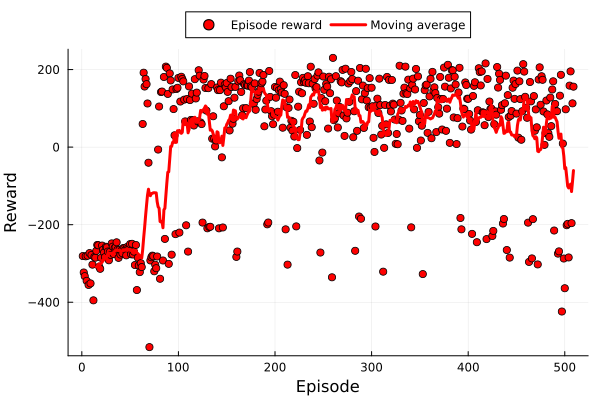

In [8]:
# Retrieve one of the models for further examination.
ex = models[1];

# Compute a moving average of the reward.
movAv(vs, n) = [sum(@view vs[i:(i+n-1)])/n for i in 1:(length(vs)-(n-1))]
nAv = 15
yMovAv = movAv(ex.hook.rewards, nAv)
xMovAv = nAv:(length(yMovAv)+nAv-1)

# Plot.
scatter(ex.hook.rewards, label="Episode reward", c=:red, ms=4, markerstrokewidth=1)
plot!(xMovAv, yMovAv, c=:red, lw=3, label="Moving average")
plot!(legend=:outertop, legendcolumns=2)
plot!(xlabel="Episode", ylabel="Reward")

# Evaluation

In [9]:
# Run and analyse a single episode.

# Set these to true and a valid path to create a gif.
saveFigs = false
figDir = "D:/_temp"

env = SwimmerEnv()

frames = []
episode_history = []

ex.policy(PRE_EPISODE_STAGE, env)
while !is_terminated(env)
    action = ex.policy(env)
    ex.policy(PRE_ACT_STAGE, env, action)
    env(action)
    # ex.policy(POST_ACT_STAGE, env)
    push!(episode_history, vcat(env.pos, action, env.reward, env.state))
    
    # Plot the flow.
    if saveFigs
        # p = gr(show=false; size=(800, 600))
        p = flood(env.circ.flow.u[:, :, 1]; shift=(-0.5, -0.5), clims=(-0.5, 1.5),
            xlabel="x [grid units]", ylabel="y [grid units]", colorbar_title="\$U_{x}/U_{\\infty}\$")

        # Plot the cylinder
        plot!(circle_shape(env.x0[1], env.x0[2], env.R), fillalpha=1,
            linecolor=:grey, c=:grey, lw=1, seriestype=[:shape,], label="")

        # Plot the start and end regions
        plot!(circle_shape(env.x0Start[1], env.x0Start[2], env.Rstart), fillalpha=0.1,
            linecolor=:green, c=:green, line=(1, :dash, 0.6), seriestype=[:shape,], label="")
        plot!(circle_shape(env.x0End[1], env.x0End[2], env.Rend), fillalpha=0.1,
            linecolor=:red, c=:red, line=(1, :dash, 0.6), seriestype=[:shape,], label="")

        # Plot the bounds for the agent.
        plot!(Shape([env.rlDomainMin[1], env.rlDomainMax[1], env.rlDomainMax[1], env.rlDomainMin[1]],
                    [env.rlDomainMin[2], env.rlDomainMin[2], env.rlDomainMax[2], env.rlDomainMax[2]]),
                    fillalpha=0.5, fillopacity=0.25, color=:grey, label="", lc=:black, line=(1, :dash, 0.6))

        # Plot the trajectory so far.
        plot!([x[1] for x in episode_history], [x[2] for x in episode_history], c=:purple, lw=2, label="Trajectory")

        # Plot the final agent speed and flow velocity.
        # vscale = 10
        # plot!([pos[1], pos[1]+vSet[1]*vscale], [pos[2], pos[2]+vSet[2]*vscale], label="\$V_{agent}\$", lc=:black, lw=2)
        # plot!([pos[1], pos[1]+vFlow[1]*vscale], [pos[2], pos[2]+vFlow[2]*vscale], label="\$V_{flow}\$", lc=:orange, lw=2)

        # Plot the start and end positions.
        scatter!([env.xStart[1]], [env.xStart[2]], label="Start", c=:green, ms=4, markerstrokewidth=0)
        scatter!([env.xEnd[1]], [env.xEnd[2]], label="End", c=:red, ms=4, markerstrokewidth=0)

        # Move the legend outside.
        plot!(legend=:outertop, legendcolumns=3)

        # Keep this plot for making an animation.
        fname = @sprintf("%06d.png", env.t)
        savefig(joinpath(figDir, fname))
        push!(frames, fname)
    end
end

In [10]:
# Save plots as a gif.
if saveFigs
    anim = Animation(figDir, frames)
    buildanimation(anim, joinpath(figDir, "animatedEpisode.gif"), fps=12, show_msg=false)
end

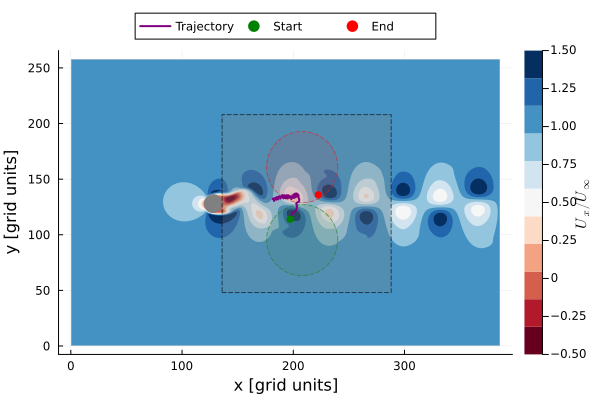

In [11]:
# Plot the final result
flood(env.circ.flow.u[:, :, 1]; shift=(-0.5, -0.5), clims=(-0.5, 1.5),
    xlabel="x [grid units]", ylabel="y [grid units]", colorbar_title="\$U_{x}/U_{\\infty}\$")

# Plot the cylinder
plot!(circle_shape(env.x0[1], env.x0[2], env.R), fillalpha=1,
    linecolor=:grey, c=:grey, lw=1, seriestype=[:shape,], label="")

# Plot the start and end regions
plot!(circle_shape(env.x0Start[1], env.x0Start[2], env.Rstart), fillalpha=0.1,
    linecolor=:green, c=:green, line=(1, :dash, 0.6), seriestype=[:shape,], label="")
plot!(circle_shape(env.x0End[1], env.x0End[2], env.Rend), fillalpha=0.1,
    linecolor=:red, c=:red, line=(1, :dash, 0.6), seriestype=[:shape,], label="")

# Plot the bounds for the agent.
plot!(Shape([env.rlDomainMin[1], env.rlDomainMax[1], env.rlDomainMax[1], env.rlDomainMin[1]],
            [env.rlDomainMin[2], env.rlDomainMin[2], env.rlDomainMax[2], env.rlDomainMax[2]]),
            fillalpha=0.5, fillopacity=0.25, color=:grey, label="", lc=:black, line=(1, :dash, 0.6))

# Plot the trajectory so.
plot!([x[1] for x in episode_history], [x[2] for x in episode_history], c=:purple, lw=2, label="Trajectory")

# Plot the start and end positions.
scatter!([env.xStart[1]], [env.xStart[2]], label="Start", c=:green, ms=4, markerstrokewidth=0)
scatter!([env.xEnd[1]], [env.xEnd[2]], label="End", c=:red, ms=4, markerstrokewidth=0)

# Move the legend outside.
plot!(legend=:outertop, legendcolumns=3)